### 初始化环境

In [1]:
# 在jupyter notebook里env.render看不到窗口
# 写一个helper类，用matplotlib刷新显示图像
# 初始化传入env，调用helper的render即可
from IPython import display # 导入display模块，用于在Jupyter Notebook中显示图像
import matplotlib
import matplotlib.pyplot as plt # 导入matplotlib库，用于绘制图像
%matplotlib inline

class GymHelper:
    def __init__(self, env, figsize = (3, 3)):
        self.env = env # 初始化Gym环境
        self.figsize = figsize # 初始化绘图窗口大小
        
        plt.figure(figsize = figsize) # 创建绘图窗口
        plt.title(self.env.spec.id) # 标题设为环境名
        self.img = plt.imshow(env.render()) # 在绘图窗口中显示初始图像
    
    def render(self, title = None):
        image_data = self.env.render() # 获取当前环境图像渲染数据
        
        self.img.set_data(image_data) # 更新绘图窗口中的图像数据
        display.display(plt.gcf()) # 刷新显示
        display.clear_output(wait = True) # 有新图片时再清除绘图窗口原有图像
        if title: # 如果有标题，就显示标题
            plt.title(title)

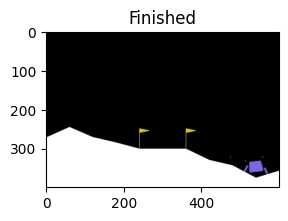

In [2]:
# 导入gym库
import gym

# 创建LunarLanderContinuous环境，指定渲染模式为rgb_array，如果是在IDE中可以改为'human'
env = gym.make('LunarLanderContinuous-v2', render_mode='rgb_array', continuous='False')
# 重置环境
env.reset()
# 创建GymHelper
gym_helper = GymHelper(env)

# 循环N次
for i in range(100):
    gym_helper.render(title = str(i)) # 渲染环境
    action = env.action_space.sample() # 从动作空间中随机选取一个动作
    observation, reward, terminated, truncated, info = env.step(action) # 执行动作
    if terminated or truncated: # 如果游戏结束，则结束循环
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

In [3]:
action = env.action_space.sample() 
action

array([0.70504874, 0.0807514 ], dtype=float32)

### DDPG

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 演员网络（策略网络）
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNetwork, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=0.0005)  # 使用Adam优化器
        self.apply(weight_init)  # 初始化模型权重

    def forward(self, state):
        # 前向传播过程
        action = torch.tanh(self.fc(state))  # 输出动作，通过tanh激活函数归一化
        return action

# 评论家网络（价值网络）
class CriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticNetwork, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.LayerNorm(256)
        )
        self.fc2 = nn.Linear(action_dim, 256)  # 输入动作的全连接层
        self.q = nn.Linear(256, 1)  # 输出Q值的线性层

        self.optimizer = optim.Adam(self.parameters(), lr=0.0005, weight_decay=0.001)  # 使用Adam优化器，并设置权重衰减
        self.apply(weight_init)  # 初始化模型权重

    def forward(self, state, action):
        # 前向传播过程
        x_s = self.fc(state)  # 状态通过第一个全连接层后接ReLU激活函数和批归一化层
        x_a = self.fc2(action)  # 动作通过全连接层
        x = torch.relu(x_s + x_a)  # 状态特征和动作特征相加后接ReLU激活函数
        q = self.q(x)  
        return q # 输出Q值


def weight_init(m):
    # 初始化模型权重的函数
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1.0)
        nn.init.constant_(m.bias, 0.0)

In [5]:
# 经验回放缓冲区
class ReplayBuffer:
    def __init__(self, max_size, state_dim, action_dim, batch_size):
        # 初始化回放缓冲区的大小、状态维度、动作维度和批次大小
        self.mem_size = max_size
        self.batch_size = batch_size
        self.mem_cnt = 0

        # 创建用于存储经验的数组
        self.state_memory = np.zeros((self.mem_size, state_dim))  # 存储状态
        self.action_memory = np.zeros((self.mem_size, action_dim))  # 存储动作
        self.reward_memory = np.zeros((self.mem_size, ))  # 存储奖励
        self.next_state_memory = np.zeros((self.mem_size, state_dim))  # 存储下一个状态
        self.terminal_memory = np.zeros((self.mem_size, ), dtype=bool)  # 存储终止标志

    def store_transition(self, state, action, reward, next_state, done):
        # 存储经验转换
        mem_idx = self.mem_cnt % self.mem_size

        self.state_memory[mem_idx] = state
        self.action_memory[mem_idx] = action
        self.reward_memory[mem_idx] = reward
        self.next_state_memory[mem_idx] = next_state
        self.terminal_memory[mem_idx] = done

        self.mem_cnt += 1

    def sample_buffer(self):
        # 从缓冲区中随机采样一个批次的经验转换
        mem_len = min(self.mem_size, self.mem_cnt)
        batch = np.random.choice(mem_len, self.batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_states = self.next_state_memory[batch]
        terminals = self.terminal_memory[batch]

        return states, actions, rewards, next_states, terminals

    def ready(self):
        # 判断缓冲区是否已准备好进行采样
        return self.mem_cnt >= self.batch_size

In [6]:
import numpy as np
import torch.nn.functional as F

class DDPG:
    def __init__(self, env, gamma=0.99, tau=0.005, action_noise=0.1, max_size=1000000, batch_size=256):
        state_dim=env.observation_space.shape[0]
        action_dim=env.action_space.shape[0]
        batch_size=256
        # 初始化DDPG算法的超参数和网络模型
        self.gamma = gamma  # 折扣因子
        self.tau = tau  # 软更新系数
        self.action_noise = action_noise  # 动作噪声幅度
        
        # 判断可用的设备是 CPU 还是 GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.actor = ActorNetwork(state_dim=env.observation_space.shape[0],
                                  action_dim=env.action_space.shape[0]).to(self.device) # 创建演员网络
        self.target_actor = ActorNetwork(state_dim=env.observation_space.shape[0],
                                  action_dim=env.action_space.shape[0]).to(self.device) # 创建目标演员网络
        self.critic = CriticNetwork(state_dim=env.observation_space.shape[0],
                                  action_dim=env.action_space.shape[0]).to(self.device)  # 创建评论家网络
        self.target_critic = CriticNetwork(state_dim=env.observation_space.shape[0],
                                  action_dim=env.action_space.shape[0]).to(self.device)  # 创建目标评论家网络

        self.memory = ReplayBuffer(max_size=max_size, state_dim=env.observation_space.shape[0],
                                  action_dim=env.action_space.shape[0], batch_size=batch_size)  # 创建回放缓冲区
        
        self.update_network_parameters(tau=1.0)  # 初始化目标网络参数与主网络参数相同

    def update_network_parameters(self, tau=None):
        # 更新目标网络参数
        if tau is None:
            tau = self.tau

        for actor_params, target_actor_params in zip(self.actor.parameters(),
                                                     self.target_actor.parameters()):
            target_actor_params.data.copy_(tau * actor_params + (1 - tau) * target_actor_params)

        for critic_params, target_critic_params in zip(self.critic.parameters(),
                                                       self.target_critic.parameters()):
            target_critic_params.data.copy_(tau * critic_params + (1 - tau) * target_critic_params)

    def remember(self, state, action, reward, next_state, done):
        # 存储经验转换
        self.memory.store_transition(state, action, reward, next_state, done)

    def choose_action(self, observation, train=True):
        # 根据当前状态选择动作
        self.actor.eval()
        state = torch.FloatTensor(observation).to(self.device)
        action = self.actor.forward(state).squeeze()

        if train:
            noise = torch.tensor(np.random.normal(loc=0.0, scale=self.action_noise),
                             dtype=torch.float).to(self.device)
            action = torch.clamp(action + noise, -1, 1)
            return action.cpu().detach().numpy()
        self.actor.train()
        return action.cpu().detach().numpy()

    def learn(self):
        # 使用经验回放进行训练
        if not self.memory.ready():
            return
        
        # 从回放缓冲区中获取一批样本
        states, actions, rewards, next_states, dones = self.memory.sample_buffer()
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.FloatTensor(np.array(actions)).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.LongTensor(np.array(dones)).to(self.device)
        
        # 使用目标演员网络生成下一个状态对应的下一个动作，并计算目标评论家网络对应的 Q 值。
        with torch.no_grad():
            next_actions = self.target_actor.forward(next_states)
            q_ = self.target_critic.forward(next_states, next_actions).view(-1)
            q_[dones] = 0.0
            target = rewards + self.gamma * q_
        
        # 使用当前评论家网络计算当前状态和动作对应的 Q 值
        q = self.critic.forward(states, actions).view(-1)

        # 计算评论家网络的损失，并根据损失进行反向传播和优化
        critic_loss = F.mse_loss(q, target)
        
        self.critic.optimizer.zero_grad()
        critic_loss.backward()
        self.critic.optimizer.step()
        
        # 生成当前状态对应的新动作，并计算演员网络的损失
        new_actions = self.actor.forward(states)
        actor_loss = -torch.mean(self.critic(states, new_actions))
        
        # 根据演员网络的损失进行反向传播和优化
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()
        
        # 更新目标网络的参数。
        self.update_network_parameters()


In [ ]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import sys
import time
import random
import collections
from tqdm import * # 用于显示进度条

# 定义超参数
max_episodes = 1500 # 训练episode数
max_steps = 1000 # 每个回合的最大步数

# 创建DDPG对象
agent = DDPG(env)
# 定义保存每个回合奖励的列表
episode_rewards = []

# 开始循环，tqdm用于显示进度条并评估任务时间开销
for episode in tqdm(range(max_episodes), file=sys.stdout):
    # 重置环境并获取初始状态
    state, _ = env.reset()
    # 当前回合的奖励
    episode_reward = 0

    # 循环进行每一步操作
    for step in range(max_steps):
        # 根据当前状态选择动作
        action = agent.choose_action(state)
        
        # 执行动作，获取新的信息
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        # 将五元组加到经验回放缓冲区
        agent.remember(state, action, reward, next_state, done)
        agent.learn()
        episode_reward += reward
        
        # 更新当前状态
        state = next_state
        if done:
            break
    # 记录当前回合奖励值
    episode_rewards.append(episode_reward)

    # 打印中间值
    if episode % 40 == 0:
        tqdm.write("Episode " + str(episode) + ": " + str(episode_reward))

Episode 0: -896.3220589740599                                                                                          
  0%|▏                                                                                | 3/1500 [00:00<02:31,  9.89it/s]

C:\Users\74760\AppData\Local\Temp\ipykernel_37664\3270783388.py:73: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  dones = torch.LongTensor(np.array(dones)).to(self.device)


Episode 40: -430.2609921038793                                                                                         
Episode 80: -538.441952068596                                                                                          
Episode 120: -581.2011617436613                                                                                        
Episode 160: -227.64773620862582                                                                                       
Episode 200: -216.7406032311452                                                                                        
Episode 240: -82.59713520968424                                                                                        
Episode 280: -87.67055723396129                                                                                        
Episode 320: -108.832376328824                                                                                         
Episode 360: -85.90654939000514         

In [ ]:
# 使用Matplotlib绘制奖励值的曲线图
plt.plot(episode_rewards)
plt.title("reward")
plt.show()

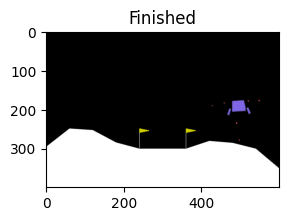

In [23]:
# 重置环境，开始新的一轮游戏
observation, _ = env.reset()
# 创建GymHelper对象来辅助显示
gym_helper = GymHelper(env)

# 开始游戏
for i in range(500):
    # 渲染环境，title为当前步骤数
    gym_helper.render(title = str(i))
    
    # 找到当前状态下的最优动作
    action = agent.choose_action(observation)
    
    # 执行action，获取新的信息
    observation, reward, terminated, truncated, info = env.step(action)

    # 如果游戏结束，则结束当前循环
    if terminated or truncated:
        break

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()